# Apply spaTrack on spatial data

This notebook uses the salamander data to demonstrates the basic functionality of spaTrack on spatial data.

In [1]:
import sti
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

Import the salamander data. 

We support spatial data and scRNA-seq data. It should be noted that cell type information must placed in 'adata.obs['cluster']', and the 2D mapping or spatial coordinates should be placed in 'X_umap' or 'X_spatial'.

In [2]:
adata = sc.read("./data/salamander/region_exp_count.T.tsv", cache=True)
coor = pd.read_table("./data/salamander/cell_coor.tsv", header=None)  # 数据空间坐标
annotation = pd.read_table("./data/salamander/cell_annot.tsv", header=None).T
cell_id = pd.read_table("./data/salamander/cell_id.tsv", header=None)
gene_id = pd.read_table("./data/salamander/gene_id.tsv", header=None)
adata.obs["cluster"] = annotation.values
adata.obsm["X_spatial"] = np.array(coor)
adata.obs.index = cell_id[0].values
adata.var.index = gene_id[0].values

Do the basic preprocessing.

In [3]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

For the convenience of subsequent trajectory inference, we only use the 'readEGC->rIPC1->IMN->nptxEX' branch.

In [4]:
adata=adata[adata.obs['cluster'].isin(['reaEGC','rIPC1','IMN','nptxEX'])].copy()

## Compute the trajectory velocity

Now, we start to calculate the trajectory velocity.

First, the cell transition probability matrix is calculated through the optiml transport theory. A 'N x N'(N is the cell number) matrix will be generated. 

There are two modes of 'single-cell' and 'spatial'. In spatial mode, cell spatial position information will be additionally utilized.

In [5]:
adata.obsp['trans']=sti.vlc.get_ot_matrix(adata,data_type='spatial')

X_pca is not in adata.obsm, automatically do PCA first.


Select the starting cluster. Can be automatic or manual.

In the automatic case, each cluster will be traversed and assumed to be the starting cluster. Then calculate the pseudotime of cells and connect the cells by the pseudotime to calculate the total probability of cell-to-cell transition. The cluster with the largest sum of transition probabilities will be selected as the starting cluster.

Here, we manually set the salamander's wound location as the starting cell, and observe how the cells at the wound develop into different types of cells around.

In [6]:
start_center=[-1050,3850]
start_cells=sti.utils.nearest_neighbors(start_center,adata.obsm['X_spatial'],n_neighbors=30)[0]

# Restrict cell type to reaEGC
ind=np.where(adata[start_cells,:].obs['cluster']=='reaEGC')

start_cells=start_cells[ind]

Infer the cell pseudotime based on the OT matrix and start cells. 

In [7]:
adata.obs['ptime']=sti.vlc.get_ptime(adata,start_cells)

Calculate the vector field velocity. 

An important factor for cell velocity is cell neighbor selection. Neighbors can be selected in terms of cell Coordinates or gene expression, corresponding to 'n_neigh_pos' and 'n_neigh_gene' respectively. Coordinate neighbors are determined by KNN and gene neighbors are determined by Euclidean distance between cell expression. Then the intersection of coordinates neighbors and embedding matrix neighbors were used as final neighbors of each spot.

Then use the direction of the cell pointing to the neighbor as the speed direction (pseudo-timing determines whether the direction is reversed), the transition probability of the cell and its neighbors as the speed, and take the average as the final speed.

Finally, cell velocities are converted to grid velocities using the distance of the cells from the grid as weights. The visualization of vector field was adapted from sctour (Li, 2022).

In [8]:
adata.uns['E_grid'],adata.uns['V_grid']=sti.vlc.get_velocity(adata,basis='spatial',n_neigh_pos=30,n_neigh_gene=0)

Display the spatial information of cells, starting cells, the cell pseudotime and the inferred cell trajectory respectively.

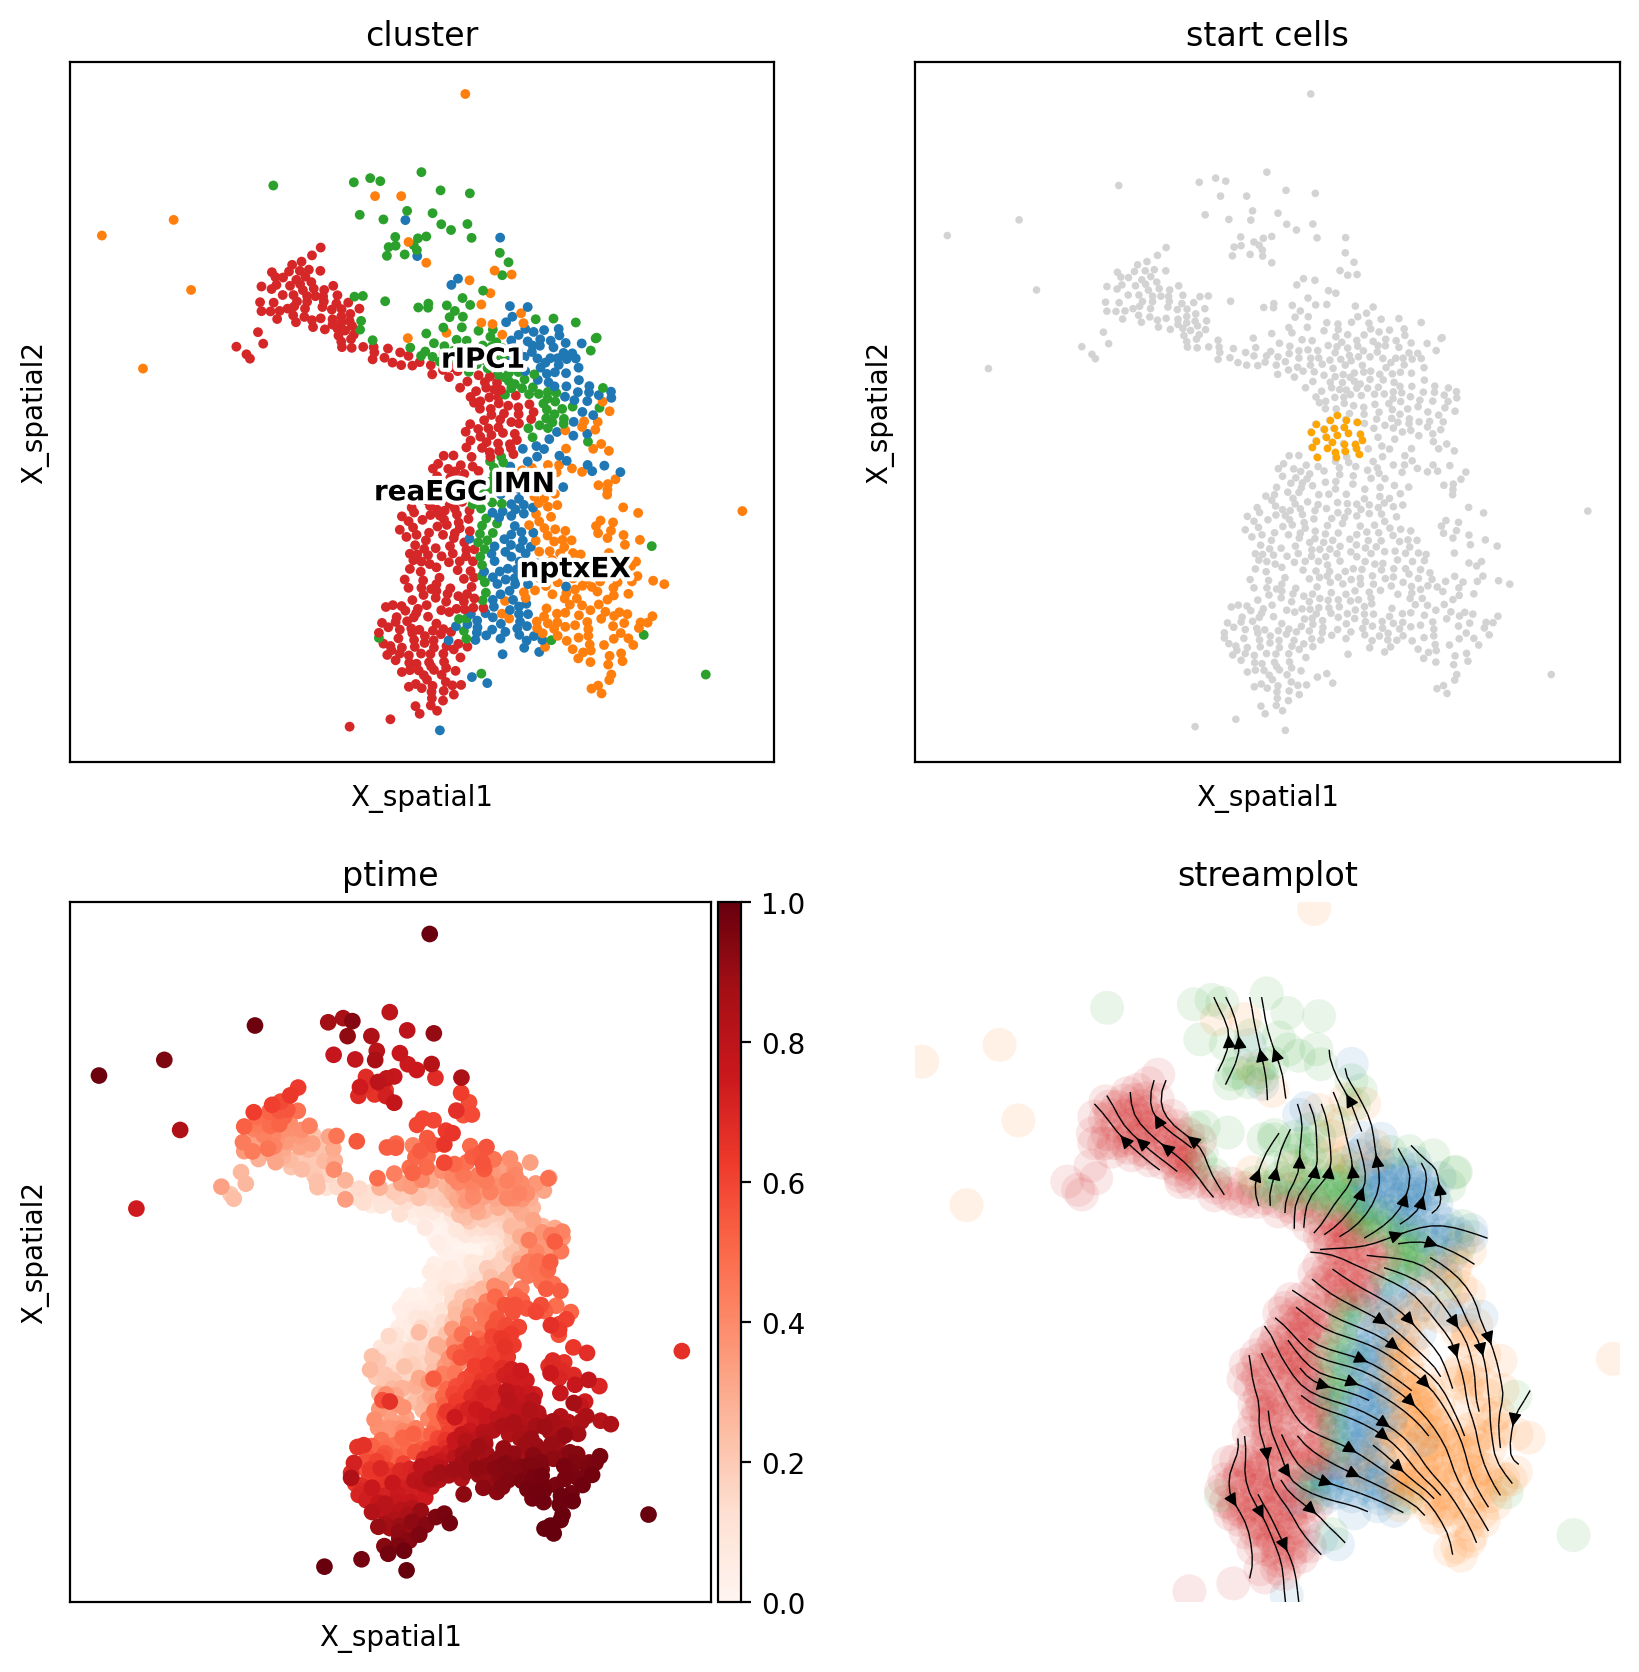

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
sc.pl.embedding(adata, basis='X_spatial', color='cluster', size=20, legend_loc='on data', ax=axs[0][0], legend_fontoutline=3, show=False, s=50)

start_points = sc.pl.embedding(adata, basis='X_spatial',ax=axs[0][1], show=False, title='start cells',s=30)
points = adata.obsm['X_spatial'][start_cells]
start_points.scatter(points[:, 0], points[:, 1], s=3, color='orange')

sc.pl.embedding(adata, basis='X_spatial', color='ptime', show=False, ax=axs[1][0], color_map='Reds', title='ptime')

vf_velocity = sc.pl.embedding(adata, basis='X_spatial', show=False, ax=axs[1][1],color='cluster', legend_loc=None, frameon=False, title='streamplot', alpha=0.1, size=600)
vf_velocity.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], color='black', linewidth=0.5,density=2)

## Key gene capture along the least action path

After completing the inference of the cell trajectory, we hope to find some cells on one trajectory in the vector field and check the changes of key genes between cells. In order to find the trajectory that best fits the vector field, we refer to the calculation of the least action path in dynamo.

First we need to reconstruct the vector field function. Here, Cell velocities are determined by each cell's predicted future state and current state, and we assume cell velocities can be sampled from a smooth, differentiable vector field function. Afterwards, we can predict the estimated cell velocity over the unsampled regions by the vector field function.

In [10]:
VecFld=sti.vf.VectorField(adata,basis='spatial')

Select the start point and the end point of the least action path.

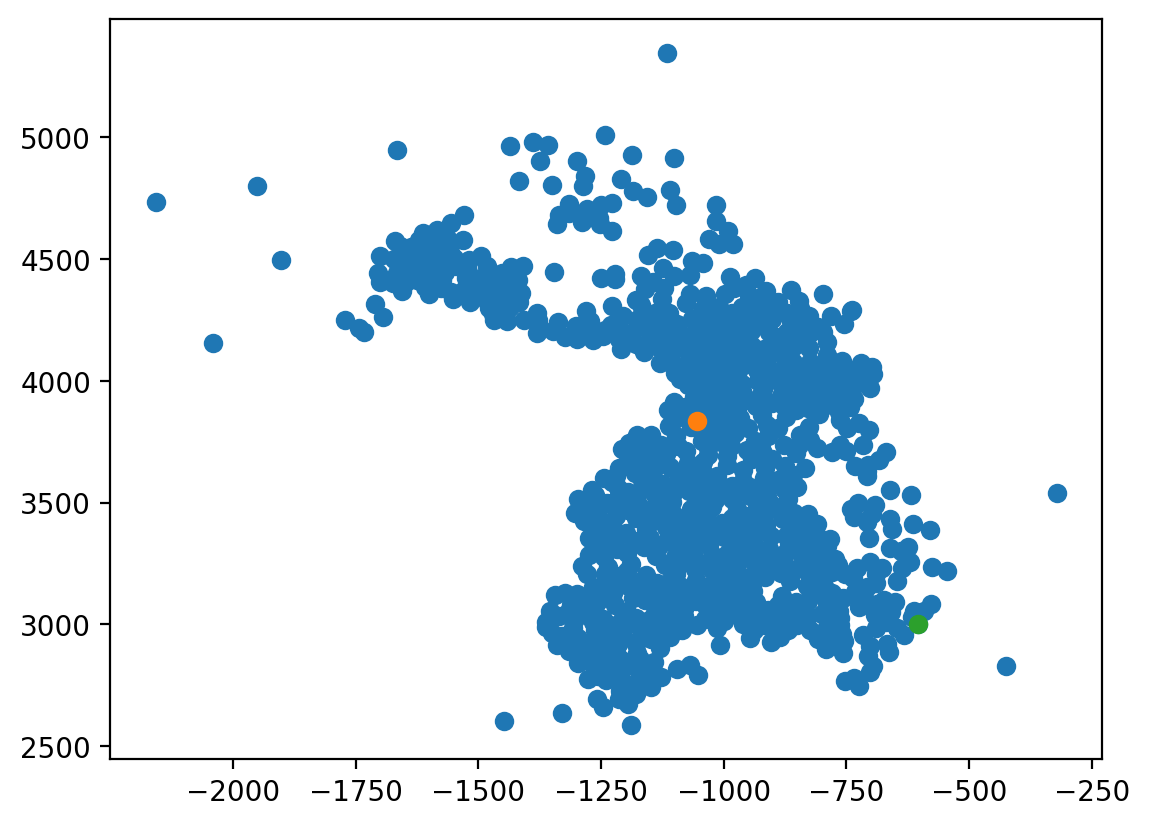

In [11]:
LAP_start_point=[-1050,3850]
LAP_end_point=[-625,3000]

LAP_start_cell=sti.utils.nearest_neighbors(LAP_start_point,adata.obsm['X_spatial'])[0][0]
LAP_end_cell=sti.utils.nearest_neighbors(LAP_end_point,adata.obsm['X_spatial'])[0][0]

plt.scatter(*adata.obsm["X_spatial"].T)
plt.scatter(*adata[LAP_start_cell].obsm['X_spatial'].T)
plt.scatter(*adata[LAP_end_cell].obsm['X_spatial'].T)

Obtain the neighbor map according to the spatial location.

In [12]:
sc.pp.neighbors(adata,use_rep='X_spatial',key_added='X_spatial',n_neighbors=100)

Calculate the least action path between given start cells and end cells. The path can be made to fit the vector field better by adjusting the number of steps of the Expectation-maximization algorithm.

In [13]:
lap=sti.lap.least_action(adata,
    init_cells=adata.obs_names[LAP_start_cell],
    target_cells=adata.obs_names[LAP_end_cell],
    vecfld=VecFld,
    basis='spatial',
    adj_key='X_spatial_distances',
    EM_steps=5,
    n_points=15
)

Plot the least action Path.

<AxesSubplot: title={'center': 'least action path'}, xlabel='X_spatial1', ylabel='X_spatial2'>

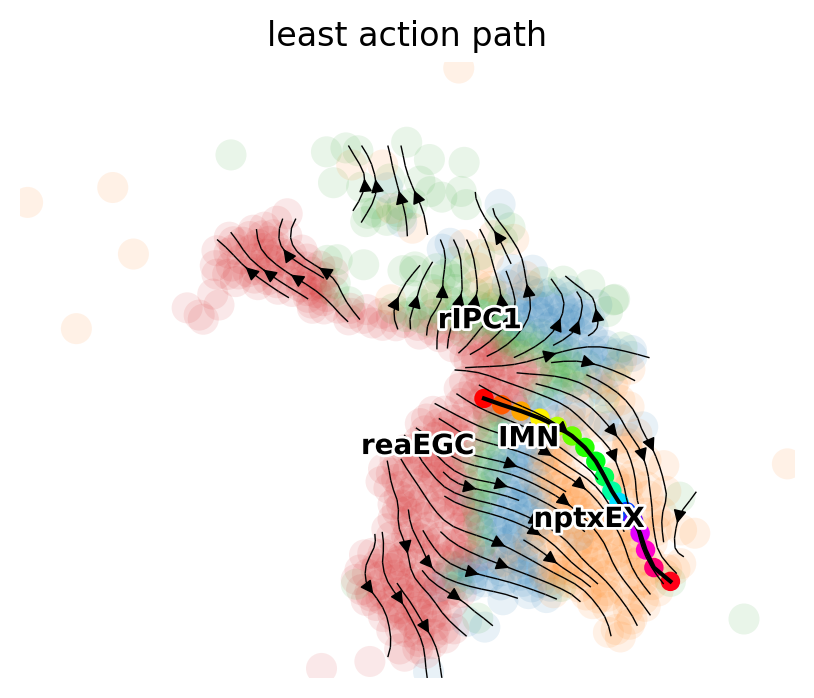

In [14]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sc.pl.embedding(adata, basis='X_spatial',show=False, ax=ax,color='cluster', legend_loc='on data',legend_fontoutline=2 ,frameon=False, title='least action path', alpha=0.1, size=500)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], density=2, color='black', linewidth=0.5)
sti.lap.plot_least_action_path(adata,basis='spatial',ax=ax)

Select neighbor cells around the least action path. And then map cells onto LAP pathways to give cells new ptimes to facilitate subsequent key gene sequencing.

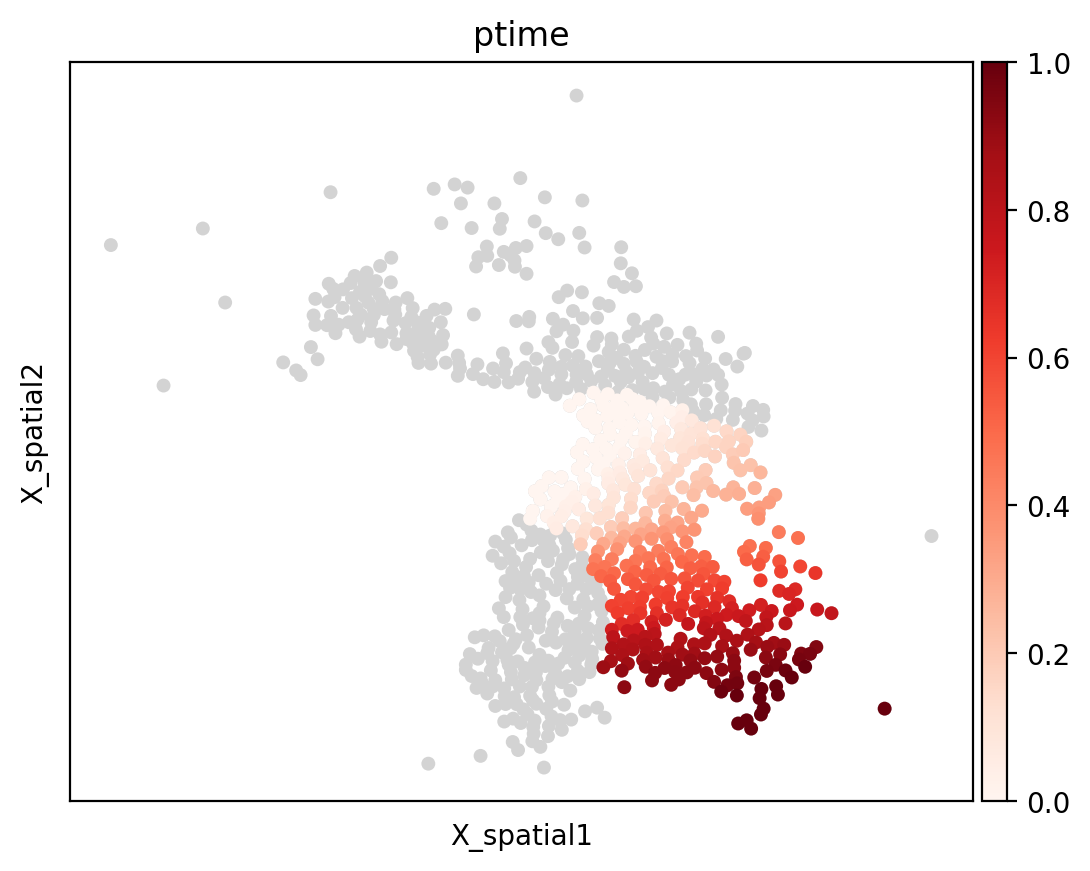

In [15]:
LAP_ptime,LAP_nbrs=sti.lap.map_cell_to_LAP(adata)
sub_adata=adata[LAP_nbrs,:]
sub_adata.obs['ptime']=LAP_ptime
sub_adata=sub_adata[np.argsort(sub_adata.obs["ptime"].values), :].copy()

ax = sc.pl.embedding(adata, basis='X_spatial',show=False,size=100)
sc.pl.embedding(sub_adata, basis='X_spatial',ax=ax, color="ptime", cmap="Reds", size=100)

Filter genes based on the cell number and differential expression.

In [16]:
sub_adata=sti.Pgene.filter_gene(sub_adata,abs_FC=0.2,min_exp_prop=0.3)

The cluster order is: reaEGC rIPC1 IMN nptxEX 

Use generalized additive model to calculate time-to-gene correlations. Then use model fitness and FDR(false discovery rate) to select key genes. Finally, gene ranking is performed according to the differential genes of different clusters

In [17]:
df_res  = sti.Pgene.ptime_gene_GAM(sub_adata,core_number=5)
df_sig_res = df_res.loc[(df_res['model_fit']>0.2) & (df_res['fdr']<0.05)]
sort_exp_sig = sti.Pgene.order_trajectory_genes(sub_adata,df_sig_res)

The number of genes for GAM model:  492


Use heatmap to display key genes associated with ptime.

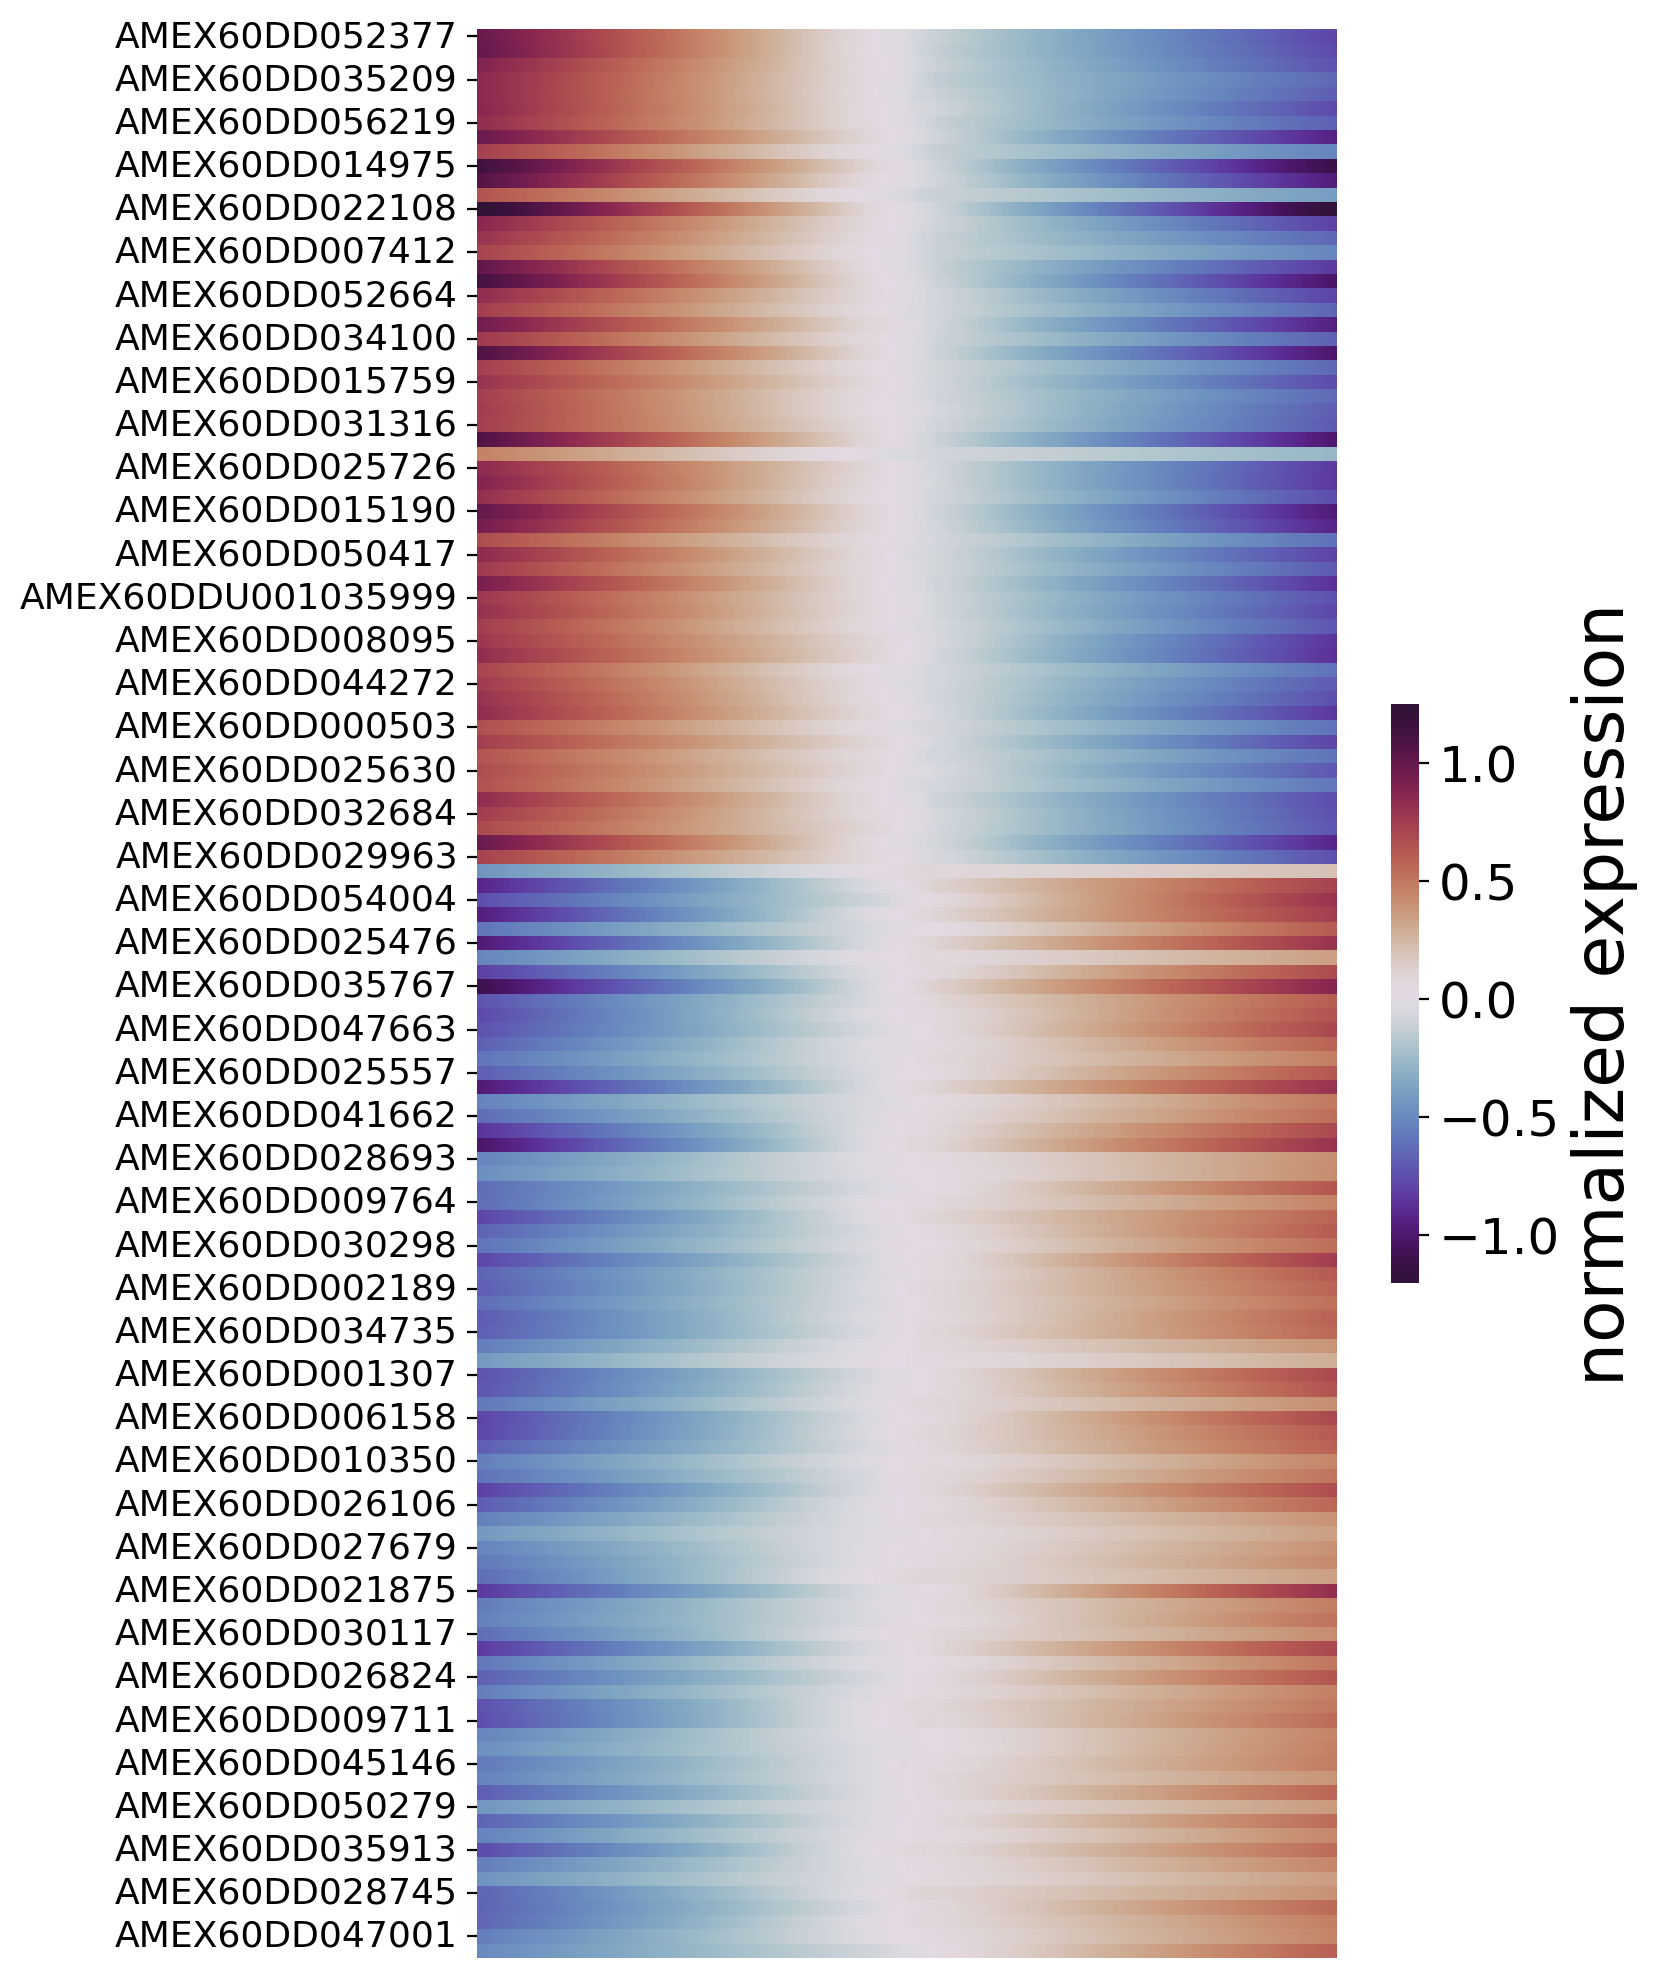

In [18]:
sti.Pgene.plot_trajectory_gene_heatmap(sort_exp_sig,smooth_length=350)

Use scatterplots to observe the expression of a single key gene at different ptimes.

<AxesSubplot: title={'center': 'AMEX60DD034100'}, xlabel='ptime', ylabel='expression'>

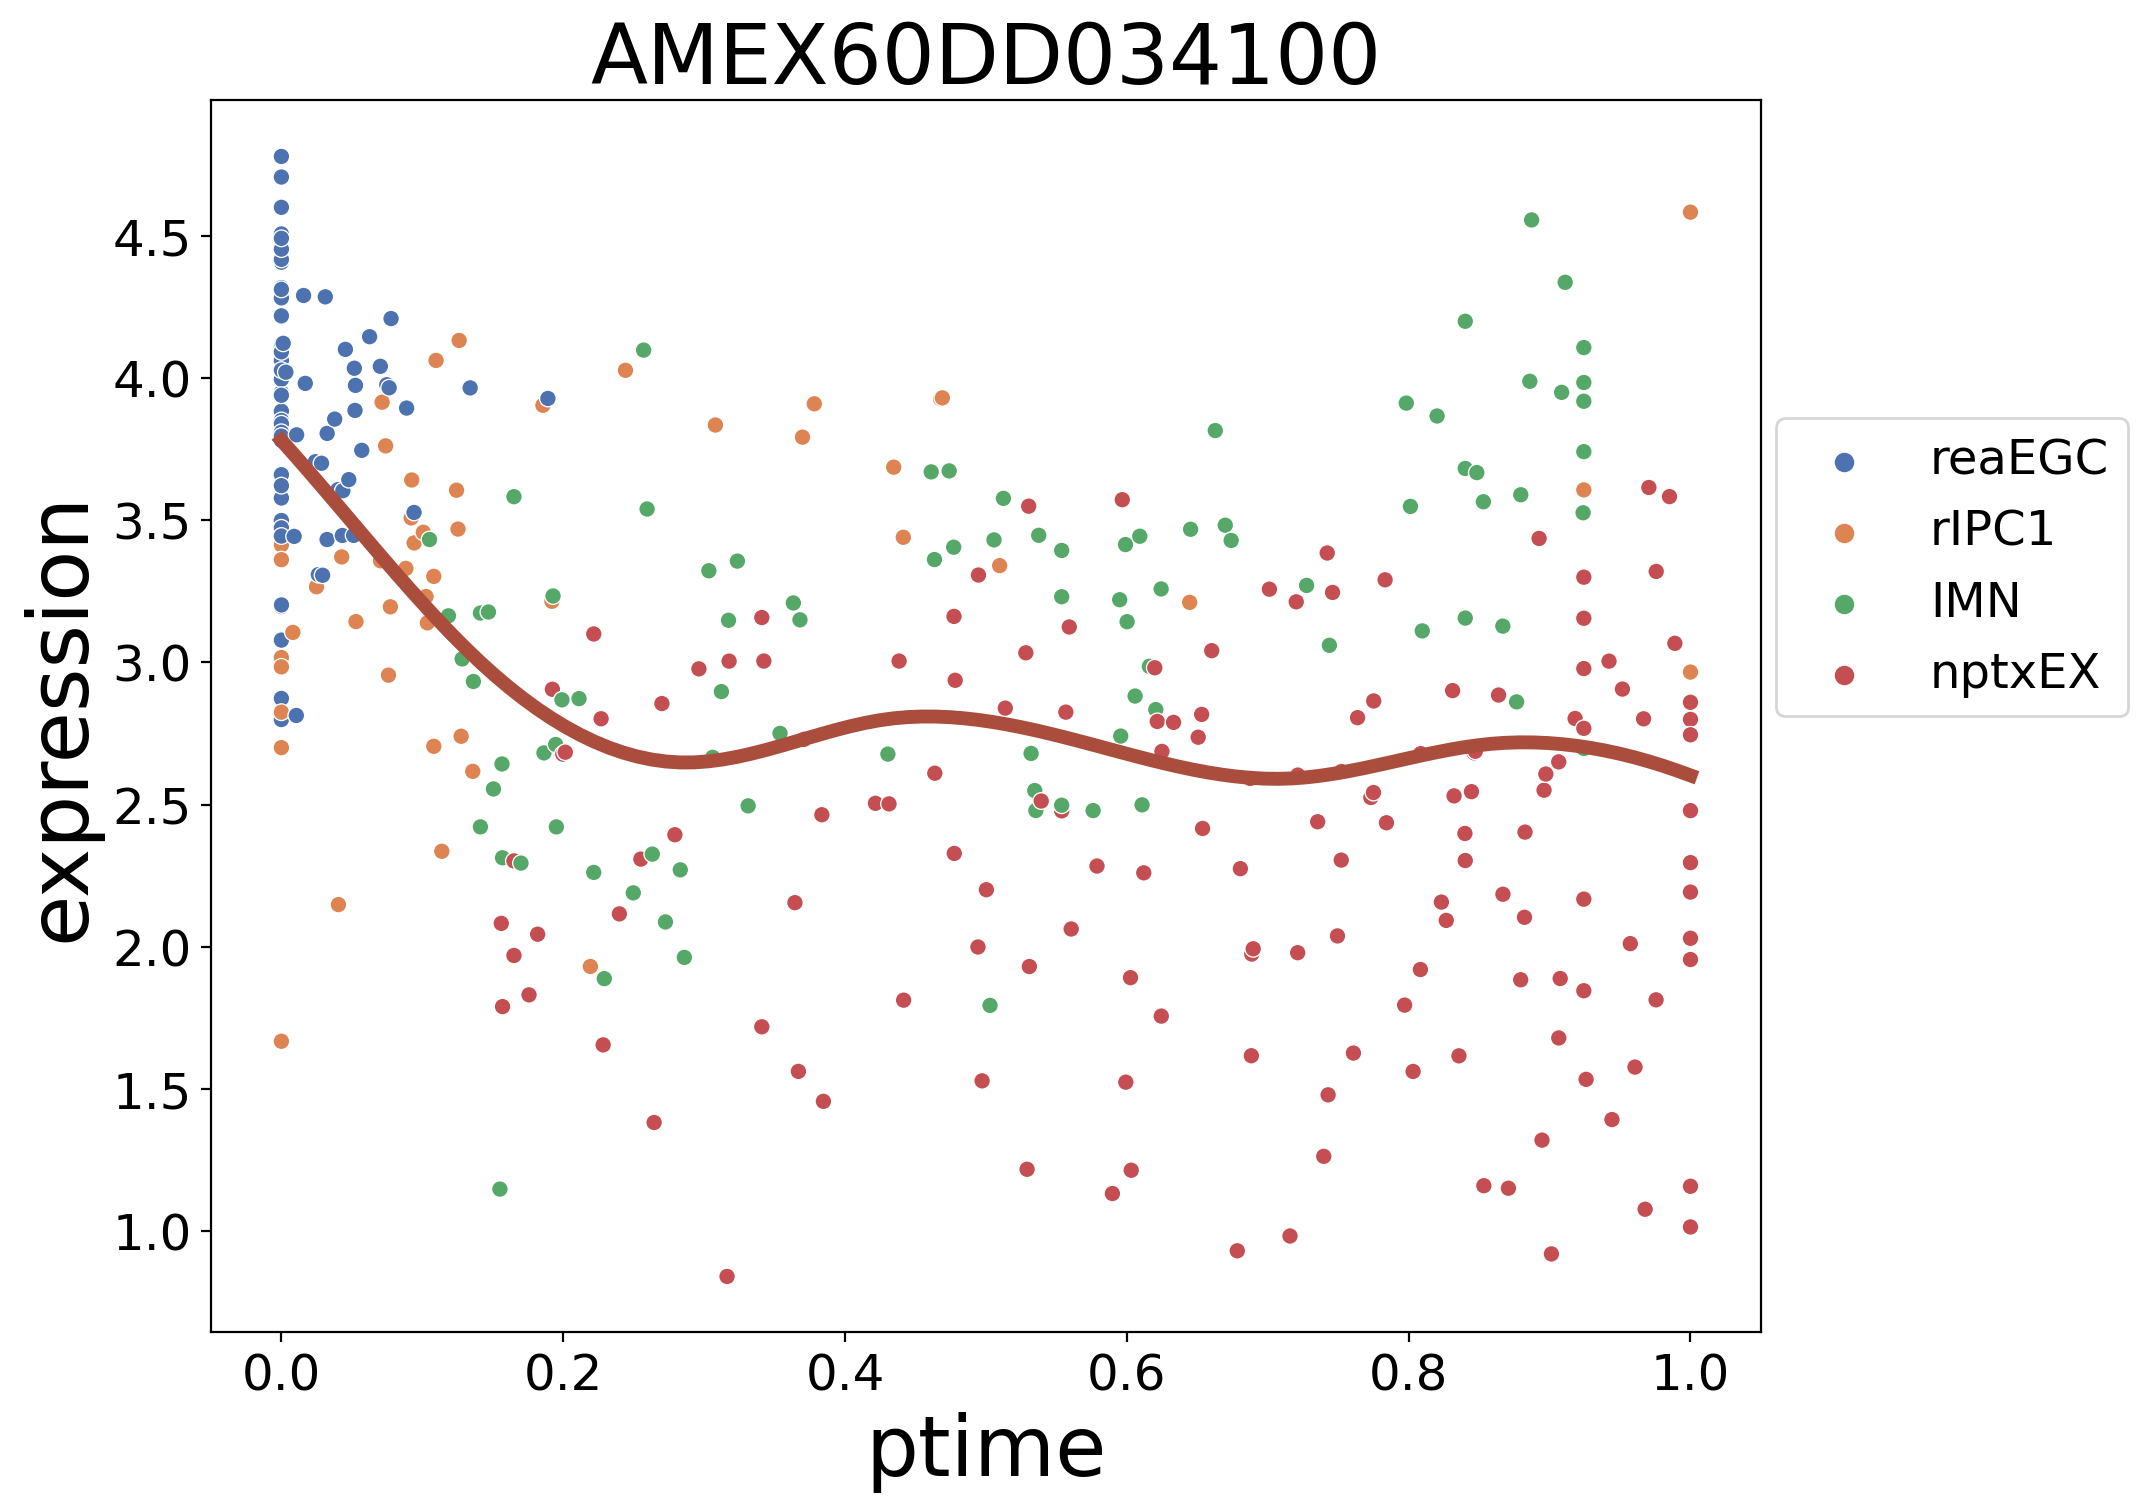

In [19]:
sti.Pgene.plot_trajectory_gene(sub_adata,gene_name='AMEX60DD034100',show_cell_type=True)